In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from efficientnet_pytorch import EfficientNet
from torch.nn.modules.distance import PairwiseDistance

class TripletDataset(Dataset):
    def __init__(self, anchor_dir, positive_dir, negative_dir, transform=None):
        self.anchor_images = datasets.ImageFolder(anchor_dir, transform=transform)
        self.positive_images = datasets.ImageFolder(positive_dir, transform=transform)
        self.negative_images = datasets.ImageFolder(negative_dir, transform=transform)

    def __len__(self):
        return min(len(self.anchor_images), len(self.positive_images), len(self.negative_images))

    def __getitem__(self, index):
        return self.anchor_images[index][0], self.positive_images[index][0], self.negative_images[index][0]


In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:

model = EfficientNet.from_pretrained('efficientnet-b7')
num_ftrs = model._fc.in_features


embedding_dimension = 128 
model._fc = nn.Linear(num_ftrs, embedding_dimension)
model = model.to(device)


Loaded pretrained weights for efficientnet-b7


In [4]:

train_dir = 'C:/Users/HARDPC/OneDrive/Pulpit/ASO_projekt/images'
val_dir = 'C:/Users/HARDPC/OneDrive/Pulpit/ASO_projekt/images'

anchor_dir_train = train_dir + '/train_stain'
positive_dir_train = train_dir + '/train_stain'
negative_dir_train = train_dir + '/defect_free'

anchor_dir_val = val_dir + '/val_stain'
positive_dir_val = val_dir + '/val_stain'
negative_dir_val = val_dir + '/val_free'

image_datasets = {
    'train': TripletDataset(anchor_dir_train, positive_dir_train, negative_dir_train, data_transforms['train']),
    'val': TripletDataset(anchor_dir_val, positive_dir_val, negative_dir_val, data_transforms['val']),
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [5]:

distance = PairwiseDistance(p=2)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [6]:

num_epochs = 15
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

   
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  
        else:
            model.eval()   

        running_loss = 0.0
        running_corrects = 0

        # Iteracja przez dane.
        for anchors, positives, negatives in dataloaders[phase]:
            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)

            optimizer.zero_grad()

            # forward propagation
            with torch.set_grad_enabled(phase == 'train'):

                anchor_embeddings = model(anchors)
                positive_embeddings = model(positives)
                negative_embeddings = model(negatives)

                loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)

                # backward + optimize 
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * anchors.size(0)

        if phase == 'train':
            step_lr_scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]

        print('{} Loss: {:.4f}'.format(phase, epoch_loss))

print('Trening zakończony')


Epoch 0/14
----------
train Loss: 0.9999
val Loss: 0.0472
Epoch 1/14
----------
train Loss: 0.9635
val Loss: 0.0388
Epoch 2/14
----------
train Loss: 0.9605
val Loss: 0.0344
Epoch 3/14
----------
train Loss: 0.8920
val Loss: 0.0261
Epoch 4/14
----------
train Loss: 0.8830
val Loss: 0.0140
Epoch 5/14
----------
train Loss: 0.9114
val Loss: 0.0057
Epoch 6/14
----------
train Loss: 0.9392
val Loss: 0.0061
Epoch 7/14
----------
train Loss: 0.8149
val Loss: 0.0035
Epoch 8/14
----------
train Loss: 0.8674
val Loss: 0.0017
Epoch 9/14
----------
train Loss: 0.8212
val Loss: 0.0004
Epoch 10/14
----------
train Loss: 0.9050
val Loss: 0.0000
Epoch 11/14
----------
train Loss: 0.8302
val Loss: 0.0000
Epoch 12/14
----------
train Loss: 0.9557
val Loss: 0.0000
Epoch 13/14
----------
train Loss: 0.7104
val Loss: 0.0000
Epoch 14/14
----------
train Loss: 0.8472
val Loss: 0.0000
Trening zakończony


[20  2 28 33 26  8 18 37 35  3 39 27 36 15 30 38 21 17 22 41 13 40  0 16
 11 14 10 31  9 29  6 24 34  5 19 25 23  1 32 12  4  7]


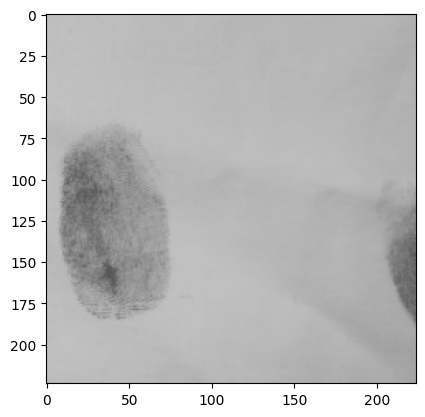

20


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Funkcja do odwrócenia transformacji
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


image_path = "C:/Users/HARDPC/OneDrive/Pulpit/ASO_projekt/images/train_stain/class1/201.jpg"
image = Image.open(image_path)
image = data_transforms['val'](image).unsqueeze(0)
image = image.to(device)

# Obliczenie osadzenia dla obrazu
with torch.no_grad():
    anchor_embedding = model(image)

# Porównanie z innymi obrazami
images_list = []
distances = []
with torch.no_grad():
    for images in dataloaders['val']:
        images = images[0].to(device)  # Uzyskanie tylko obrazów kotwiczących
        embeddings = model(images)
        dists = distance(embeddings, anchor_embedding.expand_as(embeddings)).detach().cpu().numpy()
        distances.extend(dists)
        images_list.extend(images.detach().cpu())


sorted_image_indices = np.argsort(distances)
print(sorted_image_indices)


imshow(images_list[sorted_image_indices[0]])

print(sorted_image_indices[0])
